# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
import time
import functools
import multiprocessing as mp


In [3]:
# params = {
#     'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
#     'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
#     'pathSuffixToStat': 'plane1/stat.npy',
#     'pathSuffixToOps': 'plane1/ops.npy',
#     'pref_use_NN_distances': True,
#     'use_GPU': True,
#     'pref_blurROIs': True,
#     'params_blur': {
#         'kernel_size': 7, # Edge length of kernel image. Make odd number.
#         'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
#     },
#     'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
#     'params_dIOU': {
#         'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
#         'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
#     }
# }

In [4]:
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

In [5]:
# device = torch_helpers.set_device(use_GPU=params['use_GPU'])

In [6]:
%load_ext autoreload
%autoreload 2
from ROICaT.tracking import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, cluster_assignment

In [7]:
%matplotlib notebook

# Import paths

In [8]:
def print_list(l):
    for item in l:
        print(item)

In [9]:
dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/alignment_ground_truth/NY044").resolve()

folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]

print(f'folder names of all sessions: \n{folders_allSessions}')
print(f'paths to all stat files: \n{paths_allStat}')


folder names of all sessions: 
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
paths to all stat files: 
[PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/alignment_ground_truth/NY044/0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/alignment_ground_truth/NY044/1/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/alignment_ground_truth/NY044/2/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/alignment_ground_truth/NY044/3/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/alignment_ground_truth/NY044/4/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/alignment_ground_truth/NY044/5/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/alignment_ground_truth/NY044/6/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/alignment_ground_truth/NY044/7/stat.npy')
 PosixPath('/media/rich/bigSSD/other

# Import data

In [10]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=1.0,
    new_or_old_suite2p='old',
    verbose=True,
)

data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=[72,72],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='mimg',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Starting: Importing spatial footprints from stat files
Completed: Imported 14 stat files into class as self.statFiles. Total number of ROIs: 7047. Number of ROI from each file: [542, 470, 610, 541, 517, 386, 486, 529, 533, 512, 519, 469, 458, 475]


14it [00:00, 40.29it/s]

Converted 14 spatial footprint files into small centered images in self.ROI_images.
Imported 14 FOV images into class as self.FOV_images


Imported 14 sessions of spatial footprints into sparse arrays.


<IPython.core.display.Javascript object>


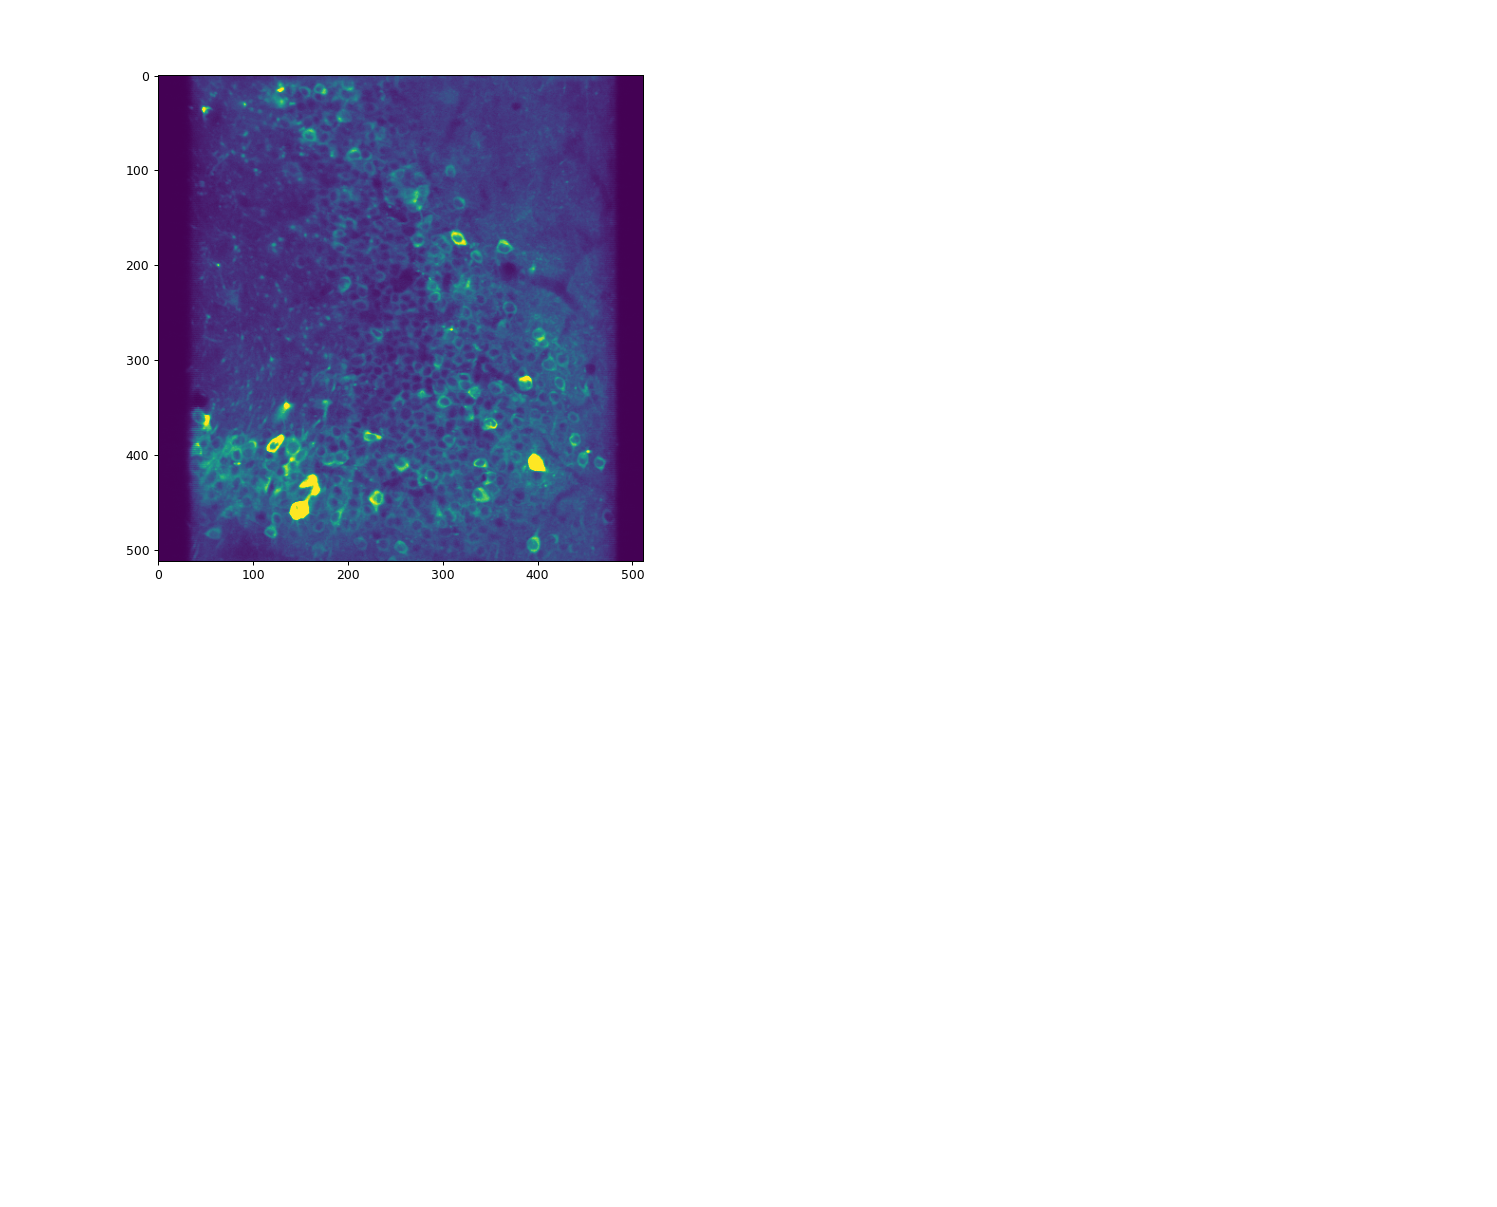

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


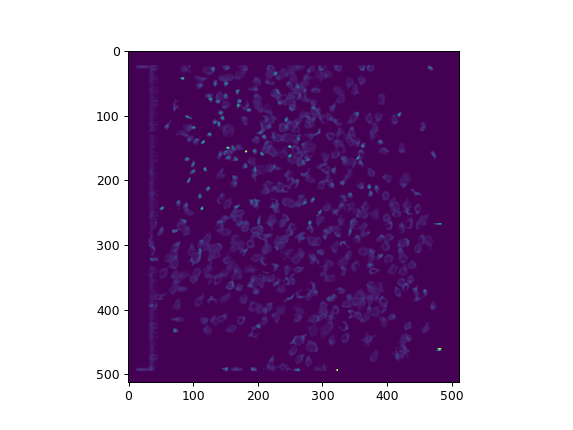

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


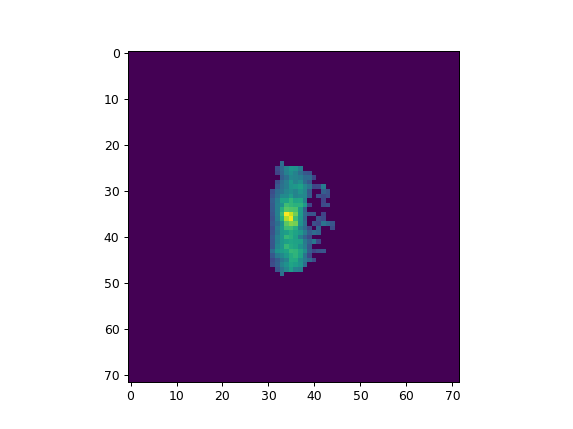

interactive(children=(IntSlider(value=0, description='i_frame', max=7046), Output()), _dom_classes=('widget-in…

In [18]:
visualization.display_toggle_image_stack(data.FOV_images)

visualization.display_toggle_image_stack([sf.max(0).reshape(data.FOV_height, data.FOV_width).toarray() for sf in data.spatialFootprints], clim=[0,0.1])

visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

# Alignment

In [21]:
aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    templateFOV=data.FOV_images[6],
    FOVs=data.FOV_images,
    ROIs=data.spatialFootprints,
    return_sparse=True,
    normalize=True,
);

100%|███████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.17s/it]


<IPython.core.display.Javascript object>


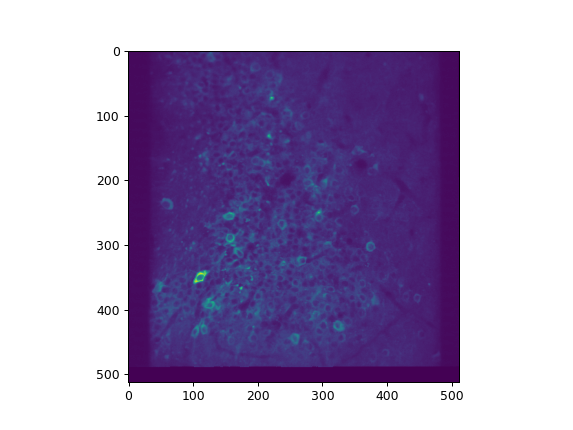

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


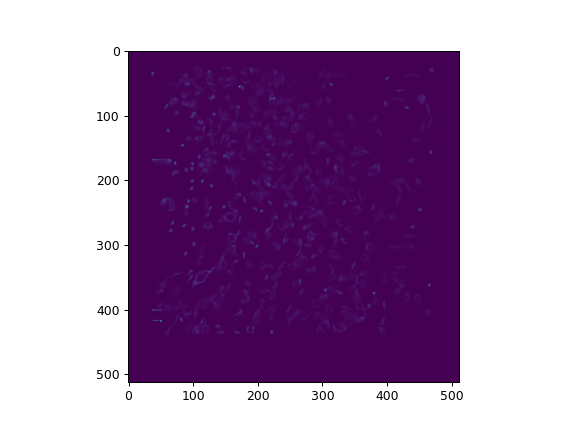

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [23]:
visualization.display_toggle_image_stack(aligner.FOVs_aligned)
visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

## Blur ROIs (optional)

In [23]:
# blurrer = blurring.ROI_Blurrer(
#     frame_shape=(data.FOV_height, data.FOV_width),
#     kernel_halfWidth=1.4,
#     device='cpu',
#     plot_kernel=True
# )

# blurrer.blur_ROIs(
#     spatialFootprints=aligner.ROIs_aligned,
#     batch_size=2000,
# );

In [24]:
# visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

## Neural network embedding distances

In [24]:
hash_dict_true = {
    'params': ('params.json', '877e17df8fa511a03bc99cd507a54403'),
    'model': ('model.py', '6ef5c29793ae16a64e43e8cab33d9ff4'),
    'state_dict': ('ConvNext_tiny__1_0_unfrozen__simCLR.pth', 'a5fae4c9ea95f2c78b4690222b2928a5'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/home/rich/Downloads/ROInet',
    download_from_gDrive='check_local_first',
    gDriveID='1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8',
    hash_dict_networkFiles=hash_dict_true,
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

# visualization.display_toggle_image_stack(roinet.ROI_images_rs)

roinet.generate_latents();

Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|███████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.85it/s]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


  0%|                                                                                       | 0/881 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: U

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network


In [25]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

## Scattering wavelet embedding distances

In [26]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 8}, 
    image_shape=data.ROI_images[0].shape[1:3], 
    device='cuda:0'
)

swt.transform(
    ROI_images=np.concatenate(data.ROI_images, axis=0),
    batch_size=100,
);

SWT initialized
Starting: SWT transform on ROIs


71it [00:02, 34.91it/s]                                                                                             

Completed: SWT transform on ROIs


In [27]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


## Compute similarities

In [28]:
sim = similarity_graph.ROI_graph(
    device='cpu',
    n_workers=-1,
    spatialFootprint_maskPower=0.8,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=50,
    block_width=50,
    overlapping_width_Multiplier=0.1,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    n_neighbors_nearestNeighbors_spatialFootprints='full',
    locality=1.0,
    verbose=True,
)

<IPython.core.display.Javascript object>


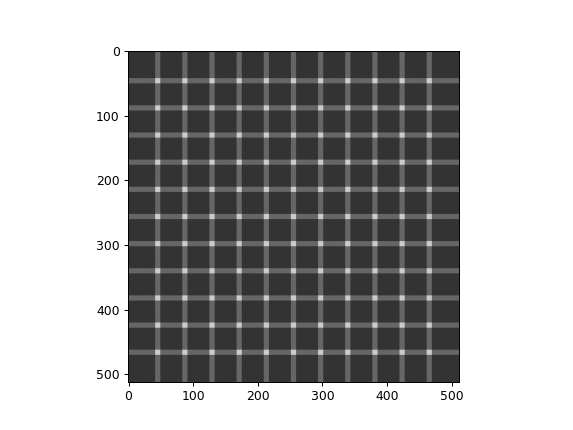

In [29]:
sim.visualize_blocks()

In [293]:
sim.compute_similarity_blockwise(
    # spatialFootprints=blurrer.ROIs_blurred,
    spatialFootprints=aligner.ROIs_aligned,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    linkage_methods=['single', 'complete', 'ward', 'average'],
    linkage_distances=helpers.bounded_logspace(0.02, 3, 70),
    min_cluster_size=3,
    max_cluster_size=None,
    batch_size_hashing=300,
);

Computing pairwise similarity between ROIs...


100%|█████████████████████████████████████████████████████████████████████████████| 144/144 [01:42<00:00,  1.40it/s]


Removing duplicate clusters...


In [ ]:
sim.compute_cluster_similarity_graph(
        cluster_similarity_reduction_intra='min',
        cluster_similarity_reduction_inter='max',
        cluster_silhouette_reduction_intra='min',
        cluster_silhouette_reduction_inter='max',
        n_workers=100,
);

In [608]:
sim.compute_cluster_scores(
    power_clusterSize=1.3, 
    power_clusterSilhouette=1.5
);

### look at results of similarity computations

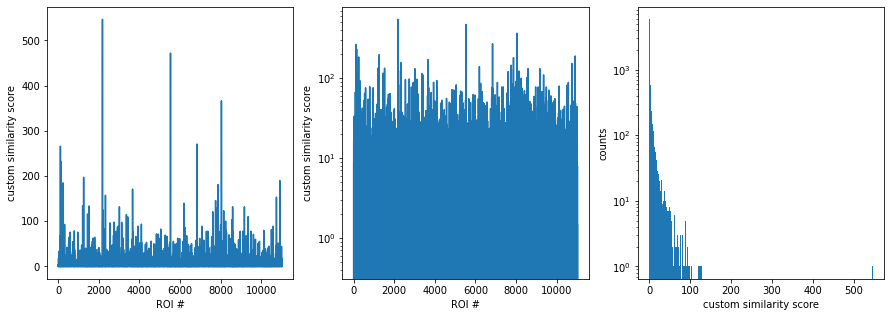

In [616]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(sim.scores.cpu())
axs[0].set_xlabel('ROI #')
axs[0].set_ylabel('custom similarity score')

axs[1].plot(sim.scores.cpu())
axs[1].set_yscale('log')
axs[1].set_xlabel('ROI #')
axs[1].set_ylabel('custom similarity score')

axs[2].hist(sim.scores.cpu(), 500)
axs[2].set_yscale('log')
# axs[2].set_xscale('log')
axs[2].set_ylabel('counts')
axs[2].set_xlabel('custom similarity score');

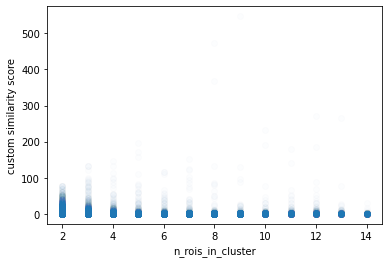

In [610]:
plt.figure()
plt.scatter((np.array(sim.cluster_bool.sum(1)).squeeze()), sim.scores, alpha=0.01)
plt.xlabel('n_rois_in_cluster')
plt.ylabel('custom similarity score');

In [613]:
min_cSil = -0.5
sim.scores[sim.c_sil <= min_cSil] = 0

# Assign optimal clusters

In [617]:
clusterAssigner = cluster_assignment.Cluster_Assigner(
    c=sim.c_sim,
    h=sim.cluster_bool.T,
    w=sim.scores,
    device='cuda:0',
    m_init=(torch.ones(sim.c_sim.shape[0])*-5 + torch.rand(sim.c_sim.shape[0])*1).type(torch.float32),
    optimizer_partial=functools.partial(torch.optim.Adam, lr=1e-1, betas=(0.9, 0.900)),
    scheduler_partial=functools.partial(torch.optim.lr_scheduler.CyclicLR, base_lr=1e-4, max_lr=1e-2, step_size_up=250, cycle_momentum=False, verbose=False),
    dmCEL_temp=1.0,
    dmCEL_sigSlope=2,
    dmCEL_sigCenter=0.5,
    dmCEL_penalty=1e0,
    sampleWeight_softplusKwargs={'beta': 75, 'threshold': 50},
    sampleWeight_penalty=1e3,
    fracWeighted_goalFrac=1.0,
    fracWeighted_sigSlope=1,
    fracWeighted_sigCenter=0.5,
    fracWeight_penalty=1e3,
    maskL1_penalty=1e-4,
    tol_convergence=1e-9,
    window_convergence=50,
    freqCheck_convergence=50,
    verbose=True,
)

In [618]:
clusterAssigner.fit(
    min_iter=1e3,
    max_iter=1e4,
    verbose=True, 
    verbose_interval=100
)

iter: 0:  loss_total: 390.3613  lr: 0.00014   loss_cs: 2.9064  loss_fracWeighted: 387.4548  loss_sampleWeight: 0.0000  loss_maskL1: 0.0001  diff_loss: nan  loss_smooth: nan
iter: 100:  loss_total: 389.0339  lr: 0.00410   loss_cs: 1.5794  loss_fracWeighted: 387.4544  loss_sampleWeight: 0.0000  loss_maskL1: 0.0001  diff_loss: nan  loss_smooth: nan
iter: 200:  loss_total: 387.9355  lr: 0.00806   loss_cs: 0.4827  loss_fracWeighted: 387.4526  loss_sampleWeight: 0.0000  loss_maskL1: 0.0002  diff_loss: nan  loss_smooth: nan
iter: 300:  loss_total: 387.6410  lr: 0.00798   loss_cs: 0.1987  loss_fracWeighted: 387.4417  loss_sampleWeight: 0.0000  loss_maskL1: 0.0006  diff_loss: nan  loss_smooth: nan
iter: 400:  loss_total: 387.5575  lr: 0.00402   loss_cs: 0.1419  loss_fracWeighted: 387.4146  loss_sampleWeight: 0.0000  loss_maskL1: 0.0010  diff_loss: nan  loss_smooth: nan
iter: 500:  loss_total: 387.5271  lr: 0.00014   loss_cs: 0.1311  loss_fracWeighted: 387.3949  loss_sampleWeight: 0.0000  loss_m

iter: 4500:  loss_total: 379.2838  lr: 0.00014   loss_cs: 0.3505  loss_fracWeighted: 378.8038  loss_sampleWeight: 0.0617  loss_maskL1: 0.0678  diff_loss: -0.0013  loss_smooth: 379.2843
iter: 4600:  loss_total: 379.2783  lr: 0.00410   loss_cs: 0.3526  loss_fracWeighted: 378.7959  loss_sampleWeight: 0.0618  loss_maskL1: 0.0680  diff_loss: -0.0039  loss_smooth: 379.2805
iter: 4700:  loss_total: 379.2641  lr: 0.00806   loss_cs: 0.3582  loss_fracWeighted: 378.7754  loss_sampleWeight: 0.0620  loss_maskL1: 0.0685  diff_loss: -0.0076  loss_smooth: 379.2680
iter: 4800:  loss_total: 379.2479  lr: 0.00798   loss_cs: 0.3643  loss_fracWeighted: 378.7521  loss_sampleWeight: 0.0623  loss_maskL1: 0.0692  diff_loss: -0.0073  loss_smooth: 379.2514
iter: 4900:  loss_total: 379.2380  lr: 0.00402   loss_cs: 0.3685  loss_fracWeighted: 378.7374  loss_sampleWeight: 0.0626  loss_maskL1: 0.0696  diff_loss: -0.0040  loss_smooth: 379.2399
iter: 5000:  loss_total: 379.2343  lr: 0.00014   loss_cs: 0.3701  loss_frac

KeyboardInterrupt: 

In [ ]:
clusterAssigner.plot_loss()

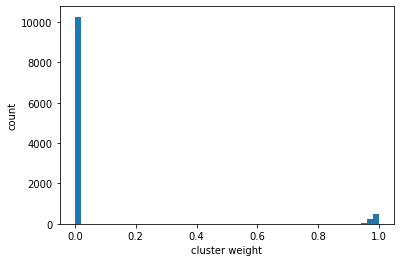

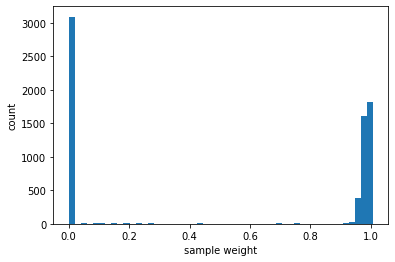

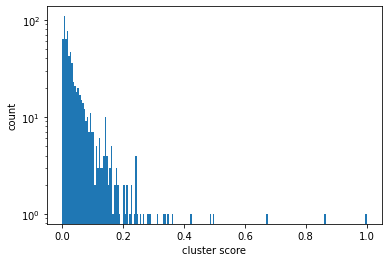

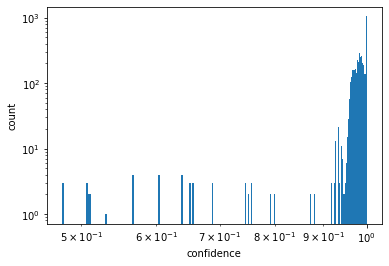

In [619]:
clusterAssigner.plot_clusterWeights()

clusterAssigner.plot_sampleWeights()

clusterAssigner.plot_clusterScores(bins=200)
plt.xscale('log')
plt.yscale('log')

Number of clusters: 703


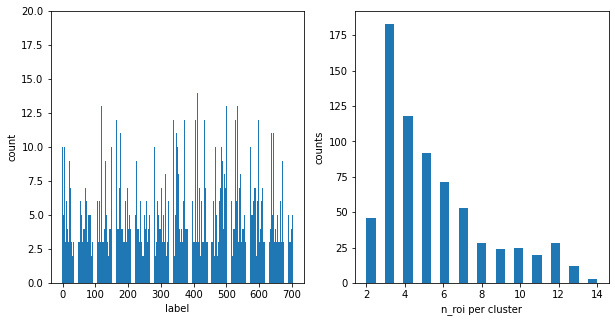

In [620]:
m_threshold=0.9

preds, confidence, scores_samples, m_bool = clusterAssigner.predict(m_threshold=m_threshold)

fig, axs = clusterAssigner.plot_labelCounts()
axs[0].set_ylim([0,20])

print(f'Number of clusters: {m_bool.sum()}')

# Visualize results

In [592]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=clusterAssigner.preds,
    confidence=clusterAssigner.confidence,
    threshold_confidence = 0.5
)

<IPython.core.display.Javascript object>


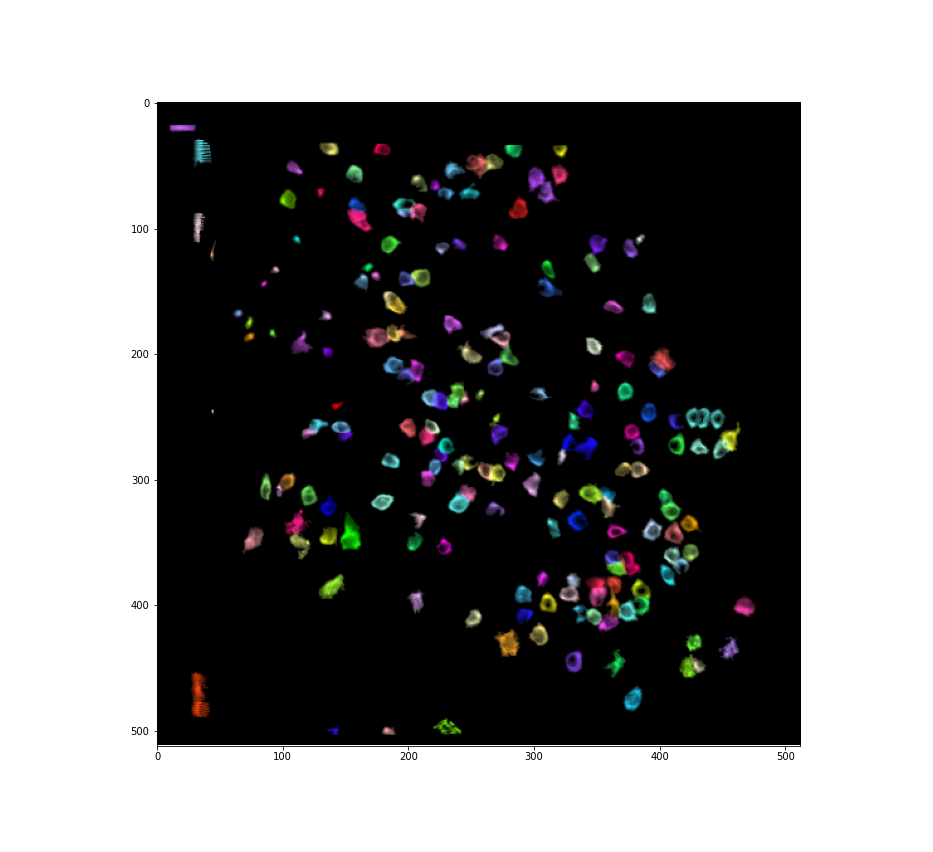

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [593]:
%matplotlib notebook
visualization.display_toggle_image_stack(FOV_clusters)

In [266]:
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

# Save results

In [40]:
dir_save = Path('/home/rich/Desktop/').resolve()
name_save = dir_allOuterFolders.name

In [41]:
preds_bySession = [preds[idx].numpy() for idx in data.sessionID_concat.T]

ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": [np.where(idx)[0] for idx in data.sessionID_concat.T]
}

helpers.simple_save(
    {
        "UCIDs": list(clusterAssigner.preds.numpy().astype(np.int64)),
        "UCIDs_bySession": preds_bySession,
        "ROIs": ROIs,
    },
    filename=dir_save / (name_save + '.rClust' '.pkl'),
#     filename='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/UCIDs.pkl'
)

In [42]:
import scipy.io

In [79]:
test = scipy.io.loadmat('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044_manually_aligned.mat', simplify_cells=True)

In [83]:
test['this_mouse']['ud']['sismat']

array([[ nan,  nan, 282., ...,  63.,  70.,  77.],
       [ 85., 359.,  nan, ...,  nan,  nan,  nan],
       [399.,  70.,  nan, ...,  nan,  nan,  nan],
       ...,
       [182., 310.,  nan, ..., 161., 324., 335.],
       [511.,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [93]:
sismat = test['this_mouse']['ud']['sismat']

In [94]:
ucid_gt = [np.ones(data.n_roi[ii])*-1 for ii in range(data.n_sessions)]

for sesh in range(sismat.shape[1]):
    for ii in range(sismat.shape[0]):
        idx = sismat[:,sesh][ii] -1
        if np.isnan(idx) == False:
#             print(sesh, idx, ii)
            ucid_gt[sesh][int(idx)] = ii

In [132]:
_, counts = np.unique(np.concatenate(ucid_gt), return_counts=True)

<IPython.core.display.Javascript object>


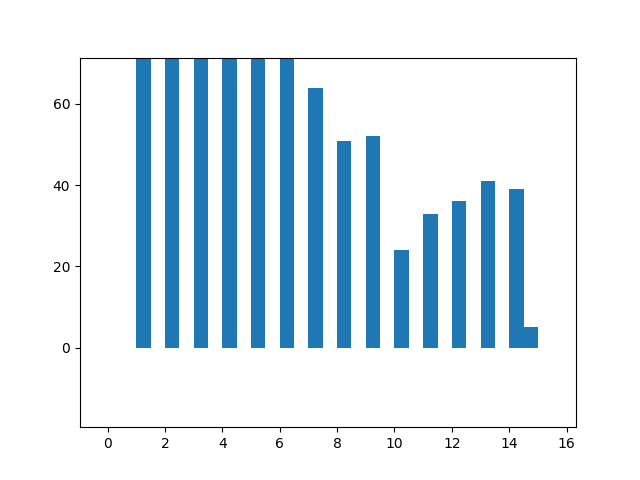

In [136]:
plt.figure()
plt.hist(counts, 30, range=(0, data.n_sessions+1));

<IPython.core.display.Javascript object>


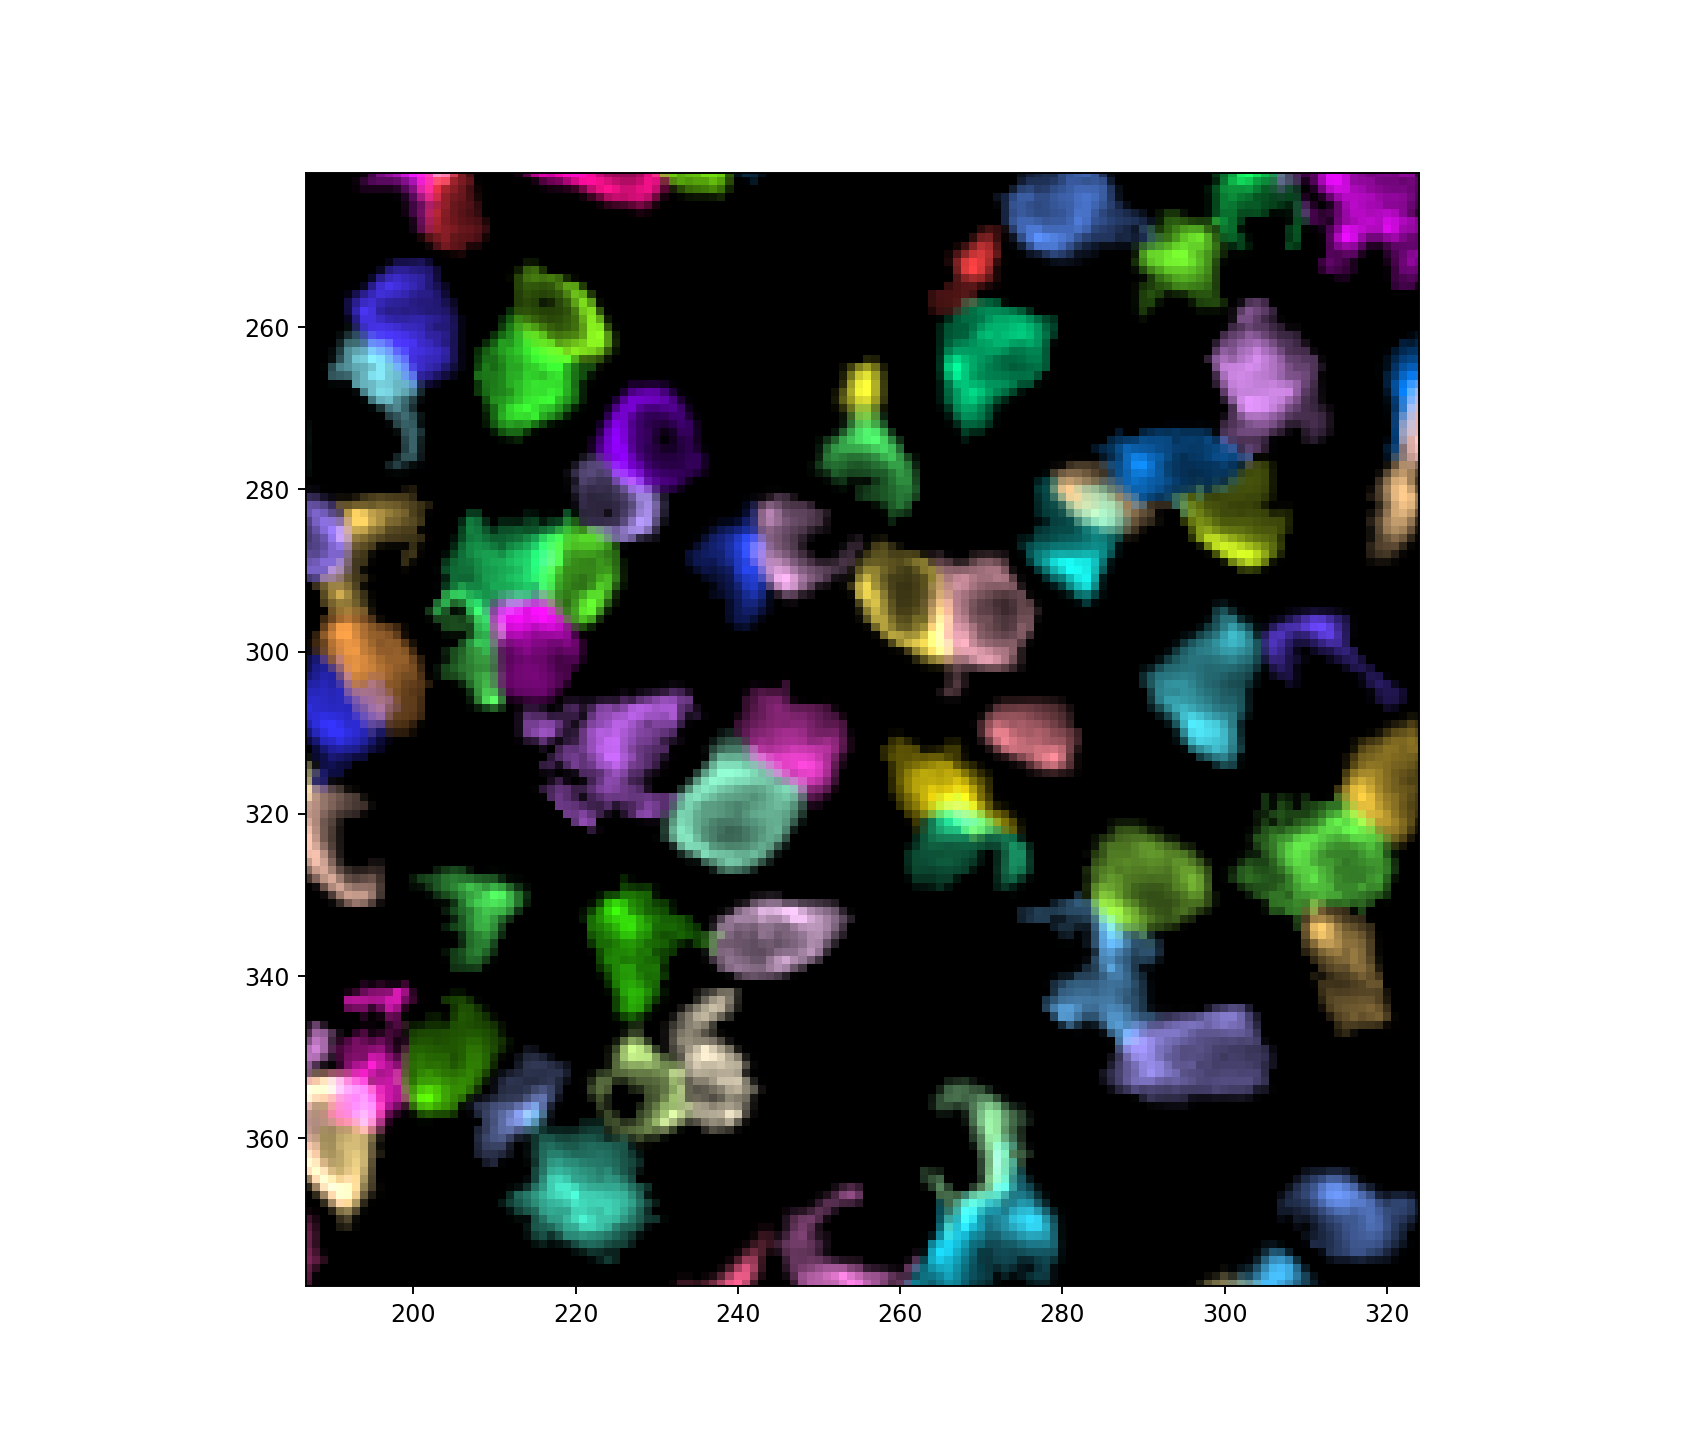

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [128]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=np.concatenate(ucid_gt),
    confidence=None,
    threshold_confidence = 0.5
)

visualization.display_toggle_image_stack(FOV_clusters)

In [602]:
ucids = clusterAssigner.preds
# ucids = np.concatenate(ucid_gt)
ucids_unique = np.unique(ucids[ucids>=0])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(aligner.ROIs_aligned)
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()

In [603]:
def crop_cluster_ims(ims):
    ims_max = np.max(ims, axis=0)
    z_im = ims_max > 0
    z_where = np.where(z_im)
    z_top = z_where[0].max()
    z_bottom = z_where[0].min()
    z_left = z_where[1].min()
    z_right = z_where[1].max()
    
    im_out = ims[:, z_bottom-1:z_top+1, z_left-1:z_right+1]
    im_out[:,(0,-1),:] = 1
    im_out[:,:,(0,-1)] = 1
    return im_out

In [604]:
ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 

/tmp/ipykernel_1433690/2585517464.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


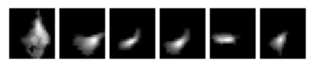

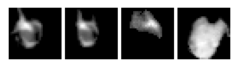

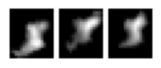

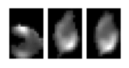

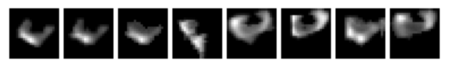

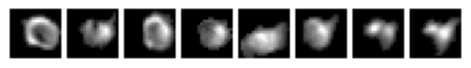

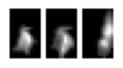

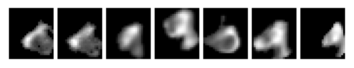

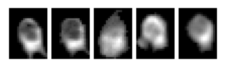

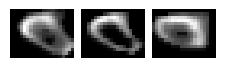

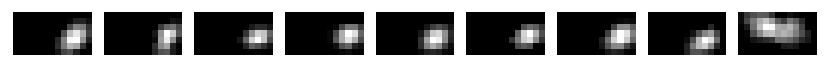

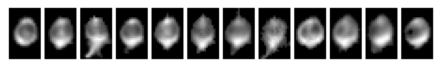

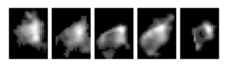

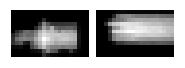

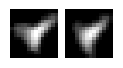

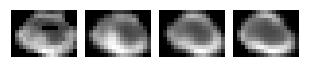

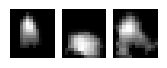

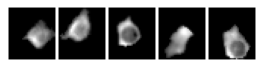

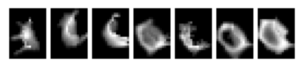

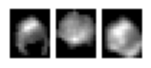

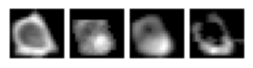

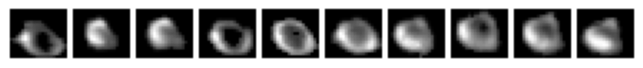

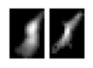

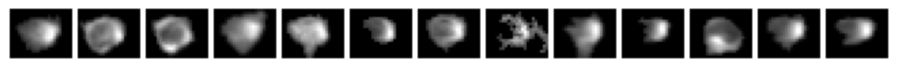

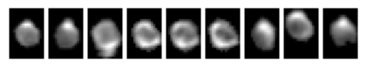

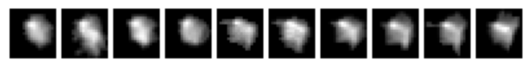

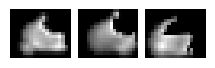

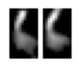

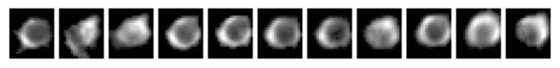

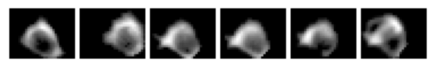

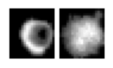

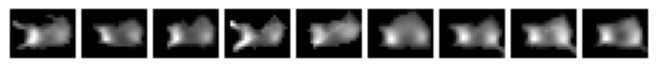

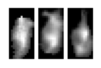

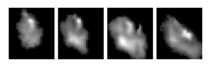

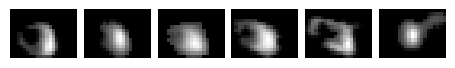

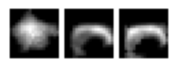

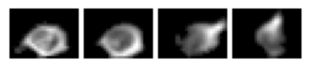

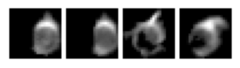

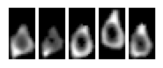

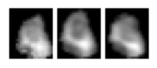

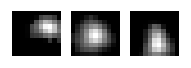

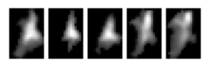

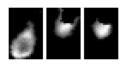

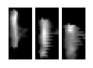

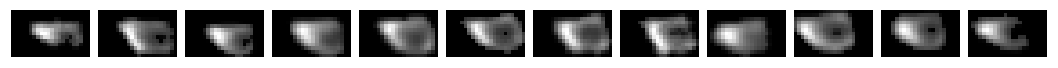

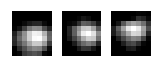

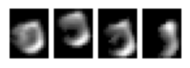

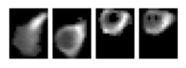

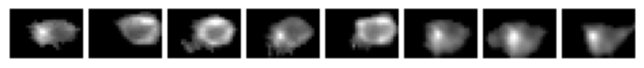

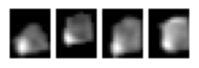

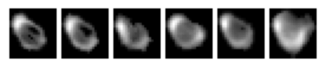

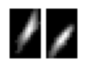

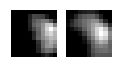

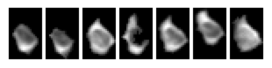

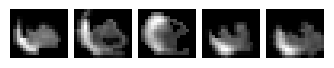

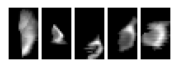

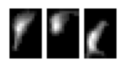

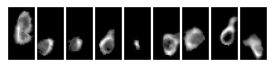

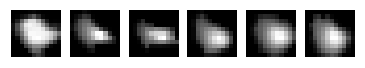

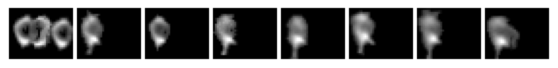

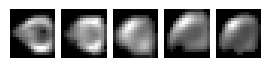

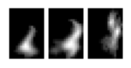

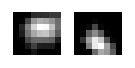

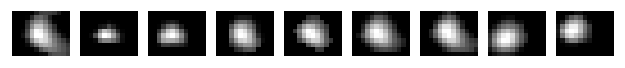

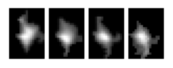

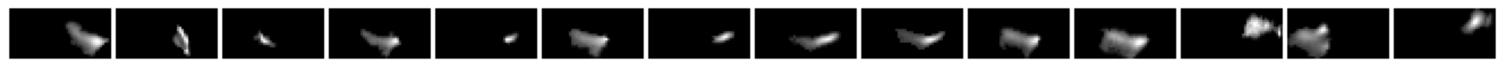

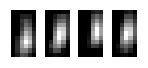

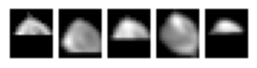

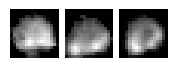

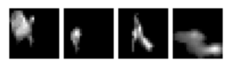

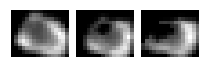

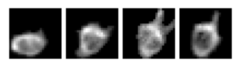

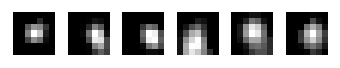

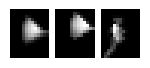

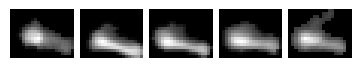

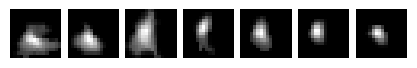

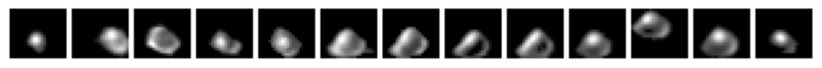

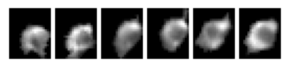

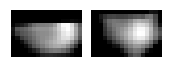

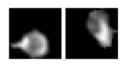

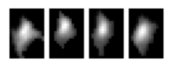

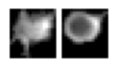

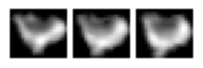

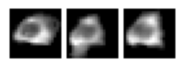

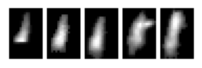

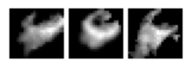

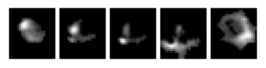

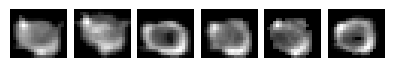

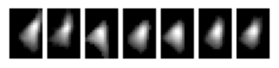

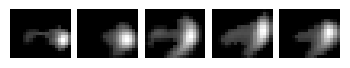

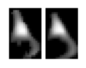

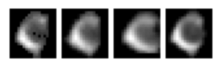

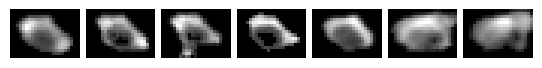

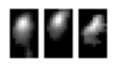

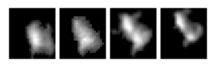

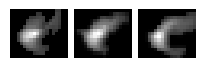

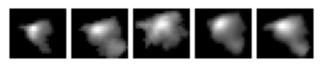

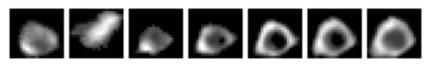

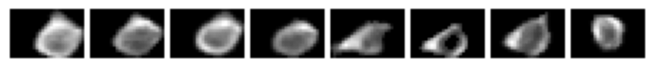

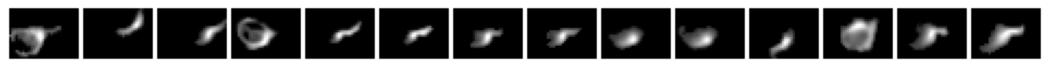

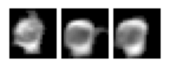

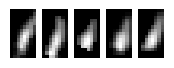

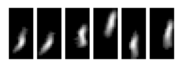

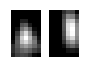

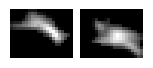

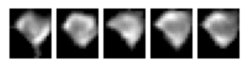

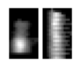

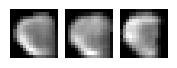

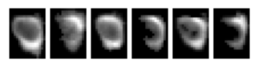

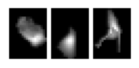

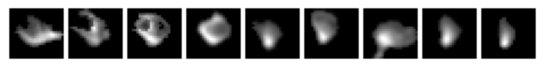

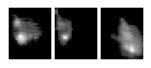

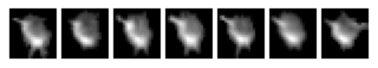

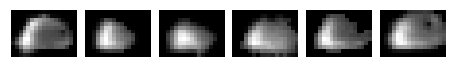

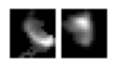

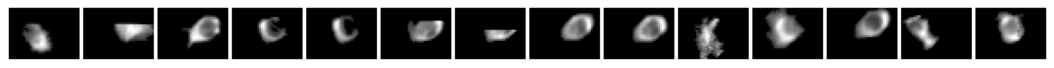

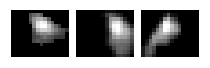

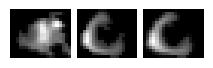

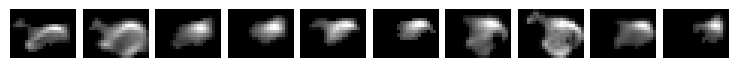

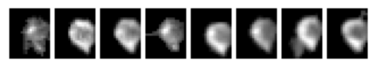

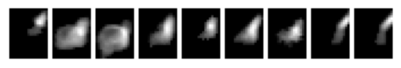

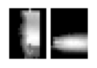

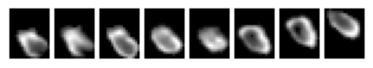

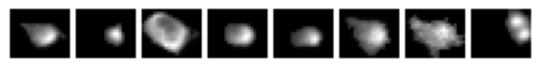

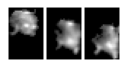

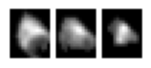

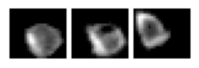

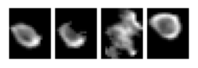

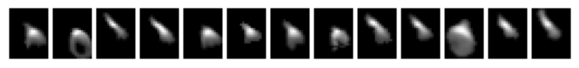

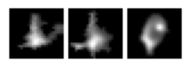

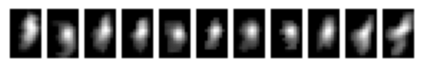

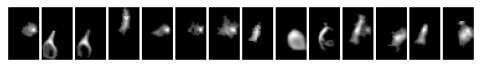

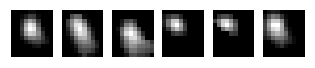

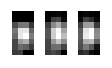

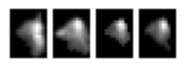

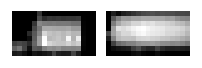

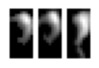

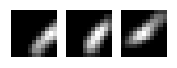

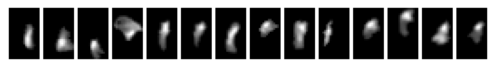

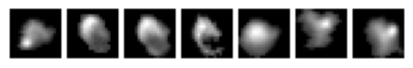

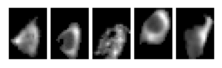

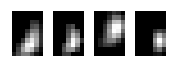

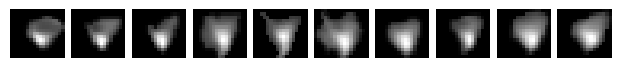

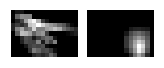

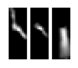

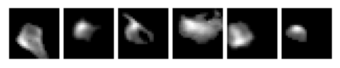

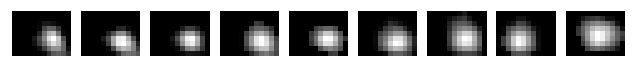

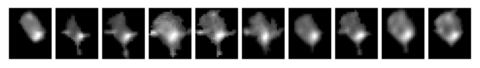

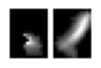

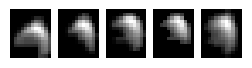

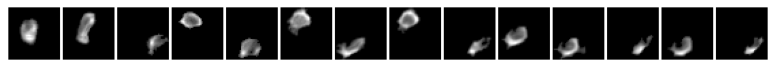

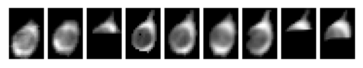

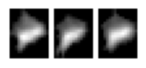

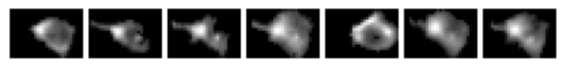

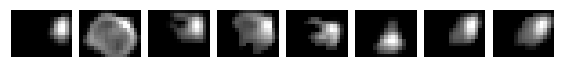

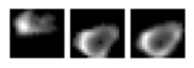

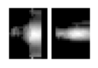

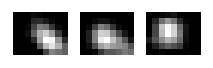

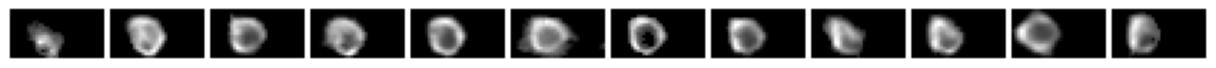

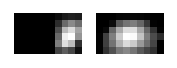

In [605]:
%matplotlib inline

for ii in range(40,200):
    plt.figure(figsize=(40,1))
    plt.imshow(ucid_sfCat[ii], cmap='gray')
    plt.axis('off')